In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.lines import Line2D

# Buat data dummy untuk harga saham
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
data = {
    'date': dates,
    'open': np.random.uniform(low=100, high=200, size=len(dates)),
    'close': np.random.uniform(low=100, high=200, size=len(dates)),
    'high': np.random.uniform(low=200, high=300, size=len(dates)),
    'low': np.random.uniform(low=50, high=100, size=len(dates))
}
df = pd.DataFrame(data)

# Buat data exog dummy
exog_data = np.random.uniform(low=0, high=10, size=len(dates))
df['exog'] = exog_data

df

,date,open,close,high,low,exog
0,2023-01-01,160.170398,122.146601,217.377487,57.057158,4.566455
1,2023-01-02,184.230592,102.946238,293.502094,62.195511,7.280263
2,2023-01-03,126.554950,189.900173,200.624714,99.191636,8.206747
3,2023-01-04,176.383495,192.279261,278.191768,85.841754,5.501190
4,2023-01-05,149.954933,174.119200,299.001323,63.670202,9.386888
...,...,...,...,...,...,...
95,2023-04-06,177.637315,191.656371,222.090685,62.886306,5.695109
96,2023-04-07,107.724177,135.382729,273.022932,77.587323,3.701375
97,2023-04-08,163.138163,126.294620,243.338729,56.363594,3.367535
98,2023-04-09,141.393980,188.243426,251.803759,79.766107,0.254523


In [36]:
# Mengatur kolom 'date' sebagai index
df.set_index('date', inplace=True)

# Memisahkan fitur target dan fitur eksogen
y = df['close']
X = df[['exog']]

# Menghitung differencing untuk stasioneritas
y_diff = y.diff().dropna()
X_diff = X.diff().dropna()

print(y_diff.head())
print(X_diff.head())


date
2023-01-02   -19.200363
2023-01-03    86.953935
2023-01-04     2.379089
2023-01-05   -18.160061
2023-01-06     0.241785
Name: close, dtype: float64
                exog
date                
2023-01-02  2.713808
2023-01-03  0.926484
2023-01-04 -2.705557
2023-01-05  3.885698
2023-01-06 -6.848833


In [37]:
# Fungsi untuk menghitung differencing
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# Fungsi untuk mengembalikan data ke nilai aslinya
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Estimasi parameter ARIMA
def estimate_arima_params(y_diff, p, q):
    # Placeholder untuk parameter AR dan MA
    phi = np.zeros(p)
    theta = np.zeros(q)

    # Estimasi parameter AR menggunakan metode OLS sederhana
    if p > 0:
        Y = y_diff[p:]
        X = np.column_stack([y_diff[i:len(y_diff) - p + i] for i in range(p)])
        phi = np.linalg.lstsq(X, Y, rcond=None)[0]

    # Estimasi parameter MA menggunakan metode OLS sederhana
    if q > 0:
        Y = y_diff[q:]
        X = np.column_stack([y_diff[i:len(y_diff) - q + i] for i in range(q)])
        theta = np.linalg.lstsq(X, Y, rcond=None)[0]

    return phi, theta

# Estimasi parameter SARIMAX
def estimate_sarimax_params(y, X, order):
    p, d, q = order
    y_diff = difference(y, d)
    X_diff = difference(X.flatten(), d).reshape(-1, 1)

    phi, theta = estimate_arima_params(y_diff, p, q)
    beta = np.linalg.lstsq(X_diff, y_diff, rcond=None)[0]

    return phi, theta, beta, y_diff

order = (1, 1, 1)
phi, theta, beta, y_diff = estimate_sarimax_params(y.values, X.values, order)

print("phi:", phi)
print("theta:", theta)
print("beta:", beta)

phi: [-0.50571602]
theta: [-0.50571602]
beta: [1.38261207]


In [40]:
# Fungsi untuk melakukan prediksi menggunakan model SARIMAX
def predict_sarimax(y, X, phi, theta, beta, y_diff, order, steps):
    p, d, q = order
    y_pred = []

    for t in range(steps):
        # AR part
        ar_term = np.dot(phi, y[-p:][::-1])

        # MA part
        ma_term = np.dot(theta, y_diff[-q:][::-1])

        # Exogenous part
        exog_term = np.dot(beta, X[-1])

        # Combine terms
        y_t = ar_term + ma_term + exog_term

        # Append prediction
        y_pred.append(y_t)

        # Update y and y_diff
        y = np.append(y, y_t)
        y_diff = np.append(y_diff, y_t - y[-2])

    # Inverse differencing
    y_pred_inv = [inverse_difference(y, yhat, d) for yhat in y_pred]

    return np.array(y_pred_inv)

steps = 100
y_pred = predict_sarimax(y.values, X.values, phi, theta, beta, y_diff, order, steps)

print("Prediksi harga saham:")
y_pred

Prediksi harga saham:


array([4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502021e+15, 4.54502021e+15, 4.54502021e+15,
       4.54502021e+15, 4.54502022e+15, 4.54502021e+15, 4.54502022e+15,
       4.54502021e+15, 4.54502022e+15, 4.54502020e+15, 4.54502023e+15,
       4.54502019e+15, 4.54502025e+15, 4.54502016e+15, 4.54502028e+15,
       4.54502012e+15, 4.54502035e+15, 4.54502003e+15, 4.54502047e+15,
       4.54501986e+15, 4.54502070e+15, 4.54501954e+15, 4.54502114e+15,
       4.54501893e+15, 4.54502198e+15, 4.54501778e+15, 4.54502357e+15,
      

C:\Users\User\AppData\Local\Temp\ipykernel_19712\2223250118.py:13: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  candlestick_data['date'] = mdates.date2num(candlestick_data['date'].dt.to_pydatetime())


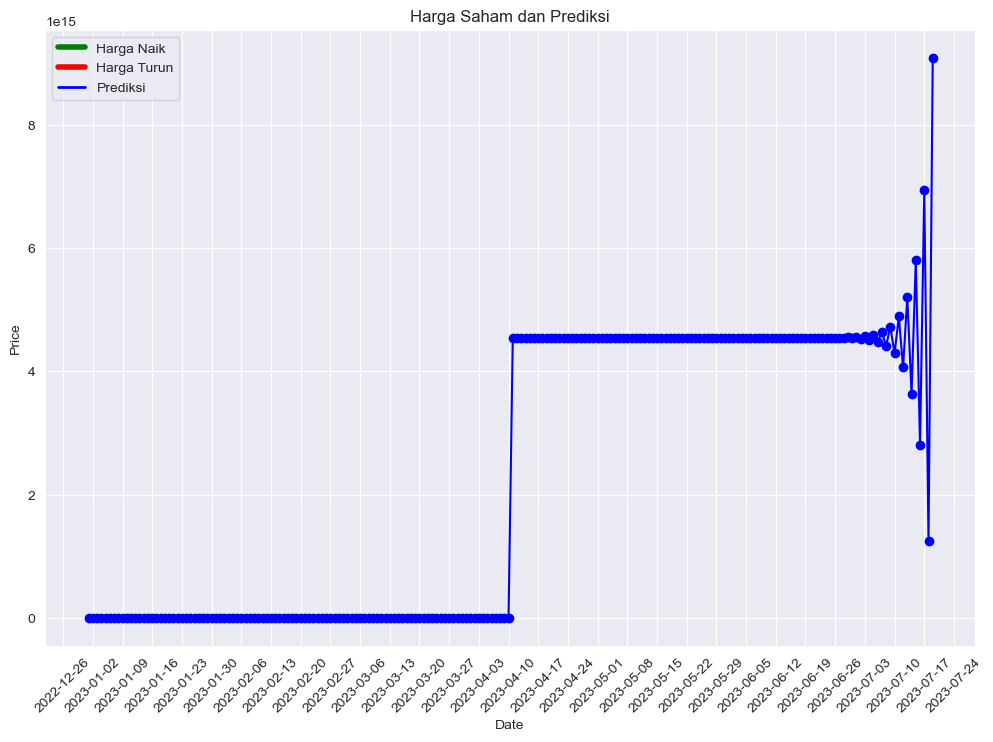

In [41]:
# Tambahkan tanggal untuk prediksi
pred_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=steps, freq='D')

# Gabungkan tanggal dan prediksi ke dalam DataFrame
pred_df = pd.DataFrame({'date': pred_dates, 'close': y_pred})
combined_df = pd.concat([df[['close']], pred_df.set_index('date')])

# Visualisasi Data
fig, ax = plt.subplots(figsize=(12, 8))

# Konversi tanggal untuk candlestick
candlestick_data = df.reset_index()
candlestick_data['date'] = mdates.date2num(candlestick_data['date'].dt.to_pydatetime())
candlestick_data = candlestick_data[['date', 'open', 'high', 'low', 'close']].values

# Plot candle chart untuk harga saham
candlestick_ohlc(ax, candlestick_data, width=0.6, colorup='green', colordown='red')

# Plot garis prediksi harga saham
ax.plot(combined_df.index, combined_df['close'], marker='o', linestyle='-', color='blue', label='Prediksi')

# Format tanggal pada sumbu x
ax.xaxis.set_major_locator(WeekdayLocator(MONDAY))
ax.xaxis.set_minor_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Tambahkan label dan judul
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Harga Saham dan Prediksi')

# Tambahkan legend
custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=2)]
ax.legend(custom_lines, ['Harga Naik', 'Harga Turun', 'Prediksi'])

plt.show()